In [60]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict, Literal, Annotated
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_core.messages import SystemMessage, HumanMessage
import operator

load_dotenv()

True

In [61]:
generator_llm = ChatGroq(model="llama-3.3-70b-versatile")
evalutor_llm = ChatGroq(model="llama-3.3-70b-versatile")
optimizer_llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [62]:
# state

class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["good", "bad"]
    feedback: str
    iteration: int
    max_iterations: int

    
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [63]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [64]:
structured_evaluator_llm =evalutor_llm.with_structured_output(TweetEvaluation)

In [65]:
# grpah object 

graph = StateGraph(TweetState)

In [66]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [67]:
def evaluate_tweet(state: TweetState):
    try:
        # prompt
        messages = [
            SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You MUST respond in JSON format."),
            HumanMessage(content=f"""
Evaluate this tweet: "{state['tweet']}"

Criteria:
1. Originality
2. Humor
3. Punchiness
4. Virality Potential
5. Format (not Q&A, under 280 chars)

Return ONLY a JSON object with exactly these fields:
{{
    "evaluation": "good" or "bad",
    "feedback": "Your feedback as one paragraph"
}}
""")
        ]

        response = structured_evaluator_llm.invoke(messages)
        
        # Handle potential None response
        if not response:
            return {
                'evaluation': 'bad',
                'feedback': 'Failed to evaluate tweet. Please try again.',
                'feedback_history': ['Evaluation failed']
            }

        return {
            'evaluation': response.evaluation,
            'feedback': response.feedback,
            'feedback_history': [response.feedback]
        }
        
    except Exception as e:
        print(f"Evaluation error: {str(e)}")
        return {
            'evaluation': 'bad',
            'feedback': f'Error in evaluation: {str(e)}',
            'feedback_history': ['Evaluation error occurred']
        }

In [68]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [69]:
def route_evaluation(state: TweetState):
    # Fix the variable name to match state dictionary
    if state['evaluation'] == 'good' or state['iteration'] >= state['max_iterations']:
        return 'good'
    else:
        return 'bad'

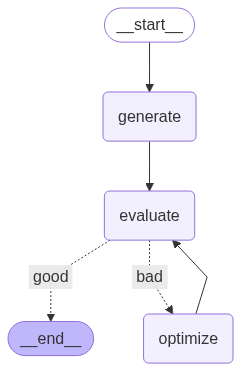

In [70]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'good': END, 'bad': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow


In [75]:
# Execute the workflow with an initial state
initial_state = {
    'topic': 'Indian Army',
    'iteration': 1,
    'max_iterations': 5}

workflow.invoke(initial_state)["tweet"]

'\n\n"Indian Army: where mom\'s discipline transforms into unstoppable swagger 💪🔥 #IndianArmy"'